# ***Here we calculate and explorate some topological properties of funtional networks***

# ***`First let's load everything we're going to need`***

In [ ]:
#import libraries
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
#Load FC, feedback type, mouse name and brain areas per sesion (sesions 9,12,14,17,21,30,32)
sessions = [9,12,14,17,21,30,32]
FCSS = []
f_types = []
areass = []
trialss = []
names = ['Henchde','Lederbergde','Lederbergde','Lederbergde','Mullerde','Richardsde','Richardsde']
for session in sessions:
  FCS = np.load('/gdrive/Shareddrives/NoNameGroup - NMA/Results/Functional Networks/FC_' + str(session) + '.npy')
  f_type = np.load('/gdrive/Shareddrives/NoNameGroup - NMA/Results/Functional Networks/feedbacktype_' + str(session) +'.npy')
  area = np.load('/gdrive/Shareddrives/NoNameGroup - NMA/Results/Functional Networks/brainareas_' + str(session) + '.npy')
  trials = np.load('/gdrive/Shareddrives/NoNameGroup - NMA/Results/Functional Networks/trials_' + str(session) +'.npy')

  FCSS.append(FCS)
  f_types.append(f_type)
  areass.append(area)
  trialss.append(trials)

In [ ]:
def entropy_dist(measure,nbins):
  hist = np.histogram(measure,bins= nbins)[0]
  prob = hist/np.sum(hist)
  prob = prob[np.nonzero(prob)]
  S = -np.sum(prob*np.log(prob)) 
  return S

def node_degree(graph):
  degree = list(graph.degree())
  degree2 = np.ones(len(degree))
  for i in range(len(degree)):
    degree2[i] = degree[i][1]
  return degree2


def super_areas(brain_areas):
  '''
  from the list with brain areas, this function construct a list with super brain areas
  input: 
  list of brain areas

  output:
  list of super brain areas
  '''
  visual = ["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"]  # visual cortex
  talamo = ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"] # thalamus
  hipocampo = ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"]  # hippocampal
  no_visual = ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP","TT"]  # non-visual cortex
  midbrain = ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"]  # midbrain
  basal_g = ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"]  # basal ganglia
  cortical_sub = ["BLA", "BMA", "EP", "EPd", "MEA"]  # cortical subplate
  total = visual + talamo + hipocampo + no_visual + midbrain + basal_g + cortical_sub
  sarea = []
  #0 visual cortex
  #1 talamo
  #2 hipocampo
  #3 no visual cortex
  #4 midbrain
  #5 basal ganglia
  #6 cortical subplates
  for i in brain_areas:
    if i in visual:
      sarea.append('visual_cortex')
    if i in talamo:
      sarea.append('thalamus')
    if i in hipocampo:
      sarea.append('hippocampus')
    if i in no_visual:
      sarea.append('non visual cortex')
    if i in midbrain:
      sarea.append('midbrain')
    if i in basal_g:
      sarea.append('basal_ganglia')
    if i in cortical_sub:
      sarea.append('cortical_subplates')
    if i not in total:
      sarea.append('other')
    
  return sarea

def topological_measures(graph,brain_areas):
  '''
  this function calculate some topological measures from a given graph
  input:
  graph: graph in the format provided for networkx
  
  output:
  measures: dictionary with some topological measures, from nodal measures this contain mean,standar desviation and entropy of the nodal measure
  '''
  #relabel nodes
  nodes_prev = np.array(list(graph.nodes()))
  dict_labels = {}
  for i in range(len(nodes_prev)):
    dict_labels[str(nodes_prev[i])] = i
  nx.relabel_nodes(graph,dict_labels)

  #take the large connected component of the graph
  nodes_prev = np.array(list(graph.nodes()))
  Gcc = sorted(nx.connected_components(graph), key=len, reverse=True)
  graph = graph.subgraph(Gcc[0])
  nodes_post = np.array(list(graph.nodes()))
  #find the index of the nodes in the big component
  index = []
  for i in range(len(nodes_post)):
    c = np.where( nodes_prev == nodes_post[i] )
    index.append(c[0][0])
  index = np.array(index)

  #filter brain areas
  brain_areas = brain_areas[index]
  sbrain_areas = super_areas(brain_areas)
  sbrain_areas = np.array(sbrain_areas)
  filter_midbrain = sbrain_areas == 'midbrain'
  filter_basal_ganglia = sbrain_areas == 'basal_ganglia'
  

  #calculate clustering
  clustering = nx.clustering(graph,weight = True)
  clustering = np.array(list(clustering.values()))
  #calculate closenes
  g_distance_dict = {(e1, e2): 1 / weight for e1, e2, weight in graph.edges(data='weight')}
  nx.set_edge_attributes(graph, g_distance_dict, 'distance')
  closeness = nx.closeness_centrality(graph,distance = "distance")
  closeness = np.array(list(closeness.values()))
  #calculate degree
  degree = node_degree(graph)
  #calculate mean geodesic distance
  geodd = nx.average_shortest_path_length(graph,weight = True)
  #calculate strenght
  FC = nx.to_numpy_array(graph)
  strenght = np.sum(FC, axis = 1)
  # calculate mean, standar desviation and entropy of degree, closeness, and clustering
  mean_clustering = np.mean(clustering)
  std_clustering = np.std(clustering)
  mean_closeness = np.mean(closeness)
  std_closeness = np.std(closeness)
  mean_degree = np.mean(degree)
  std_degree = np.std(degree)
  mean_strenght = np.mean(strenght)
  std_strenght= np.std(strenght)
  entropy_closeness = entropy_dist(closeness,nbins = 25)
  entropy_strenght = entropy_dist(strenght,nbins = 25)
  entropy_clustering = entropy_dist(clustering,nbins = 25)
  entropy_degree = entropy_dist(degree,nbins = 25)
  #calculate small world coefficient
  smallworld = mean_clustering/geodd

  #calculate local measure
  mean_clustering_midbrain = np.mean(clustering[filter_midbrain])
  mean_clustering_basal_ganglia = np.mean(clustering[filter_basal_ganglia])
  std_clustering_midbrain = np.std(clustering[filter_midbrain])
  std_clustering_basal_ganglia = np.std(clustering[filter_basal_ganglia])

  mean_degree_midbrain = np.mean(degree[filter_midbrain])
  mean_degree_basal_ganglia = np.mean(degree[filter_basal_ganglia])
  std_degree_midbrain = np.std(degree[filter_midbrain])
  std_degree_basal_ganglia = np.std(degree[filter_basal_ganglia])

  mean_strenght_midbrain = np.mean(strenght[filter_midbrain])
  mean_strenght_basal_ganglia = np.mean(strenght[filter_basal_ganglia])
  std_strenght_midbrain = np.std(strenght[filter_midbrain])
  std_strenght_basal_ganglia = np.std(strenght[filter_basal_ganglia])

  mean_closeness_midbrain = np.mean(closeness[filter_midbrain])
  mean_closeness_basal_ganglia = np.mean(closeness[filter_basal_ganglia])
  std_closeness_midbrain = np.std(closeness[filter_midbrain])
  std_closeness_basal_ganglia = np.std(closeness[filter_basal_ganglia])




  #put all this in a dictionary
  measures = {'degree':degree,'mean_degree':mean_degree, 'std_degree':std_degree,'entropy_degree':entropy_degree,
            'closeness':closeness,'mean_closeness':mean_closeness, 'std_closeness':std_closeness,'entropy_closeness':entropy_closeness,
            'strenght':strenght,'mean_strenght':mean_strenght, 'std_strenght':std_strenght,'entropy_strenght':entropy_strenght,
            'clustering':clustering,'mean_clustering':mean_clustering, 'std_clustering':std_clustering,'entropy_clustering':entropy_clustering,
            'geodd': geodd,
            'smallworld': smallworld, 
            'mean_clustering_midbrain':mean_clustering_midbrain,'mean_clustering_basal_ganglia':mean_clustering_basal_ganglia,'std_clustering_midbrain':std_clustering_midbrain,'std_clustering_basal_ganglia':std_clustering_basal_ganglia,
            'mean_degree_midbrain':mean_degree_midbrain,'mean_degree_basal_ganglia':mean_degree_basal_ganglia,'std_degree_midbrain':std_degree_midbrain,'std_degree_basal_ganglia':std_degree_basal_ganglia,
            'mean_strenght_midbrain':mean_strenght_midbrain,'mean_strenght_basal_ganglia':mean_strenght_basal_ganglia,'std_strenght_midbrain':std_strenght_midbrain,'std_strenght_basal_ganglia':std_strenght_basal_ganglia,
            'mean_closeness_midbrain':mean_closeness_midbrain,'mean_closeness_basal_ganglia':mean_closeness_basal_ganglia,'std_closeness_midbrain':std_closeness_midbrain,'std_closeness_basal_ganglia':std_closeness_basal_ganglia}
  return measures

def topological_measures_session(FCS,reward,session,trials,threshold,brain_areas):
  ntrials = len(trials)
  #global
  mean_degree = np.ones(ntrials)
  mean_closeness = np.ones(ntrials)
  mean_clustering = np.ones(ntrials)
  mean_strenght = np.ones(ntrials)

  std_strenght = np.ones(ntrials)
  std_degree = np.ones(ntrials)
  std_closeness = np.ones(ntrials)
  std_clustering = np.ones(ntrials)

  entropy_degree = np.ones(ntrials)
  entropy_closeness = np.ones(ntrials)
  entropy_clustering = np.ones(ntrials)
  entropy_strenght = np.ones(ntrials)

  geodd = np.ones(ntrials)
  smallworld = np.ones(ntrials)

  #local
  mean_degree_midbrain = np.ones(ntrials)
  mean_closeness_midbrain = np.ones(ntrials)
  mean_clustering_midbrain = np.ones(ntrials)
  mean_strenght_midbrain = np.ones(ntrials)

  std_strenght_midbrain = np.ones(ntrials)
  std_degree_midbrain = np.ones(ntrials)
  std_closeness_midbrain = np.ones(ntrials)
  std_clustering_midbrain = np.ones(ntrials)

  mean_degree_basal_ganglia = np.ones(ntrials)
  mean_closeness_basal_ganglia = np.ones(ntrials)
  mean_clustering_basal_ganglia = np.ones(ntrials)
  mean_strenght_basal_ganglia = np.ones(ntrials)

  std_strenght_basal_ganglia = np.ones(ntrials)
  std_degree_basal_ganglia = np.ones(ntrials)
  std_closeness_basal_ganglia = np.ones(ntrials)
  std_clustering_basal_ganglia = np.ones(ntrials)


  for trial in range(ntrials):
    FC = FCS[trial]
    FC = FC*(FC > threshold)
    graph = nx.from_numpy_array(FC)
    measures = topological_measures(graph,brain_areas)

    #local

    mean_degree[trial] = measures['mean_degree']
    mean_closeness[trial] = measures['mean_closeness']
    mean_clustering[trial] = measures['mean_clustering']
    mean_strenght[trial] = measures['mean_strenght']

    std_strenght[trial] = measures['std_strenght']
    std_degree[trial] = measures['std_degree']
    std_closeness[trial] = measures['std_closeness']
    std_clustering[trial] = measures['std_clustering']

    entropy_degree[trial] = measures['entropy_degree']
    entropy_closeness[trial] = measures['entropy_closeness']
    entropy_clustering[trial] = measures['entropy_clustering']
    entropy_strenght[trial] = measures['entropy_strenght']

    geodd[trial] = measures['geodd']
    smallworld[trial] = measures['smallworld']

    #global
    mean_degree_midbrain[trial] = measures['mean_degree_midbrain']
    mean_closeness_midbrain[trial] = measures['mean_closeness_midbrain']
    mean_clustering_midbrain[trial] = measures['mean_clustering_midbrain']
    mean_strenght_midbrain[trial] = measures['mean_strenght_midbrain']

    std_strenght_midbrain[trial] = measures['std_strenght_midbrain']
    std_degree_midbrain[trial] = measures['std_degree_midbrain']
    std_closeness_midbrain[trial] = measures['std_closeness_midbrain']
    std_clustering_midbrain[trial] = measures['std_clustering_midbrain']

    mean_degree_basal_ganglia[trial] = measures['mean_degree_basal_ganglia']
    mean_closeness_basal_ganglia[trial] = measures['mean_closeness_basal_ganglia']
    mean_clustering_basal_ganglia[trial] = measures['mean_clustering_basal_ganglia']
    mean_strenght_basal_ganglia[trial] = measures['mean_strenght_basal_ganglia']

    std_strenght_basal_ganglia[trial] = measures['std_strenght_basal_ganglia']
    std_degree_basal_ganglia[trial] = measures['std_degree_basal_ganglia']
    std_closeness_basal_ganglia[trial] = measures['std_closeness_basal_ganglia']
    std_clustering_basal_ganglia[trial] = measures['std_clustering_basal_ganglia']


  measures_sesion = {'reward':reward,'session':np.array([session]*(ntrials)),'trial':trials,'mean_degree':mean_degree, 'std_degree':std_degree,'entropy_degree':entropy_degree,
        'mean_strenght':mean_strenght, 'std_strenght':std_strenght,'entropy_strenght':entropy_strenght,
        'mean_closeness':mean_closeness, 'std_closeness':std_closeness,'entropy_closeness':entropy_closeness,
        'mean_clustering':mean_clustering, 'std_clustering':std_clustering,'entropy_clustering':entropy_clustering,
        'geodd': geodd,
        'smallworld': smallworld,
        'mean_clustering_midbrain':mean_clustering_midbrain,'mean_clustering_basal_ganglia':mean_clustering_basal_ganglia,'std_clustering_midbrain':std_clustering_midbrain,'std_clustering_basal_ganglia':std_clustering_basal_ganglia,
        'mean_degree_midbrain':mean_degree_midbrain,'mean_degree_basal_ganglia':mean_degree_basal_ganglia,'std_degree_midbrain':std_degree_midbrain,'std_degree_basal_ganglia':std_degree_basal_ganglia,
        'mean_strenght_midbrain':mean_strenght_midbrain,'mean_strenght_basal_ganglia':mean_strenght_basal_ganglia,'std_strenght_midbrain':std_strenght_midbrain,'std_strenght_basal_ganglia':std_strenght_basal_ganglia,
        'mean_closeness_midbrain':mean_closeness_midbrain,'mean_closeness_basal_ganglia':mean_closeness_basal_ganglia,'std_closeness_midbrain':std_closeness_midbrain,'std_closeness_basal_ganglia':std_closeness_basal_ganglia}
  return measures_sesion

# ***`calculate topological measures and organize in a dictionary`***

In [ ]:
for i in range(3,5):
  measures = topological_measures_session(FCSS[i],f_types[i],sessions[i],trialss[i],0.02,areass[i])
  data = pd.DataFrame(measures)
  data.to_csv('/gdrive/Shareddrives/NoNameGroup - NMA/Results/Topological measures/all_measures_session_' + str(sessions[i])+'.csv' )
  #save_dict(measures,'/gdrive/Shareddrives/NoNameGroup - NMA/Results/Topological measures/measures_session_' + str(sessions[i]) )

# ***Check some networks***

In [ ]:
import networkx as nx 
grafo = nx.from_numpy_array(FC)
Gcc = sorted(nx.connected_components(grafo), key=len, reverse=True)
grafo = grafo.subgraph(Gcc[0])
nx.draw(grafo)

In [ ]:
nodos = list(grafo.nodes())
for j in range(len(nodos)):
  grafo.nodes[nodos[j]]['area'] = sarea[j]

In [ ]:
nx.write_graphml(grafo,'/gdrive/Shareddrives/NoNameGroup - NMA/Resultados/Redes funcionales/FC_reward.graphml')

In [ ]:
a = np.array(['hola','adios'])
b = a == 'hola'
print(b)

[ True False]


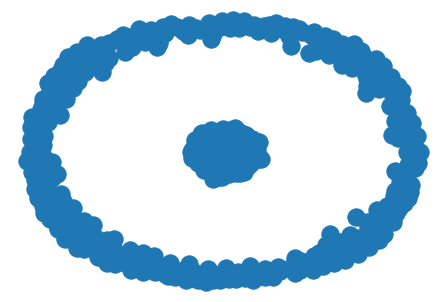

In [ ]:
nx.draw(graph)

In [ ]:
FC = FCSS[0][10]
graph = nx.from_numpy_array(FC)


In [ ]:
nodes_prev = np.array(list(graph.nodes()))
dict_labels = {}
for i in range(len(nodes_prev)):
  dict_labels[str(nodes_prev[i])] = i
nx.relabel_nodes(graph,dict_labels)



In [ ]:
print(dict_labels)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10, '11': 11, '12': 12, '13': 13, '14': 14, '15': 15, '16': 16, '17': 17, '18': 18, '19': 19, '20': 20, '21': 21, '22': 22, '23': 23, '24': 24, '25': 25, '26': 26, '27': 27, '28': 28, '29': 29, '30': 30, '31': 31, '32': 32, '33': 33, '34': 34, '35': 35, '36': 36, '37': 37, '38': 38, '39': 39, '40': 40, '41': 41, '42': 42, '43': 43, '44': 44, '45': 45, '46': 46, '47': 47, '48': 48, '49': 49, '50': 50, '51': 51, '52': 52, '53': 53, '54': 54, '55': 55, '56': 56, '57': 57, '58': 58, '59': 59, '60': 60, '61': 61, '62': 62, '63': 63, '64': 64, '65': 65, '66': 66, '67': 67, '68': 68, '69': 69, '70': 70, '71': 71, '72': 72, '73': 73, '74': 74, '75': 75, '76': 76, '77': 77, '78': 78, '79': 79, '80': 80, '81': 81, '82': 82, '83': 83, '84': 84, '85': 85, '86': 86, '87': 87, '88': 88, '89': 89, '90': 90, '91': 91, '92': 92, '93': 93, '94': 94, '95': 95, '96': 96, '97': 97, '98': 98, '99': 99, '100': 100, '101': 